# Used Car Price Prediction

## Import Data

In [1]:
# Libraries
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
import gradio as gr
import joblib
from sklearn.preprocessing import OrdinalEncoder

# Daten einlesen
df_sales = pd.read_csv("vehicles.csv", nrows=200000)
df_specs = pd.read_csv("data.csv")

/usr/local/python/3.12.1/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Merge

In [2]:
# Rename damit Spaltennamen für Merge übereinstimmen
df_specs.rename(columns={'Make': 'manufacturer', 'Model' : 'model', 'Year': 'year'}, inplace=True)

# Alphanumerische Werte Einheitlich machen mit to lower
df_sales['manufacturer'] = df_sales['manufacturer'].str.lower().str.strip()
df_sales['model'] = df_sales['model'].str.lower().str.strip()

df_specs['manufacturer'] = df_specs['manufacturer'].str.lower().str.strip()
df_specs['model'] = df_specs['model'].str.lower().str.strip()

# Engine HP aufgrund manufacturer, model, year gruppieren und den Durchschnitt berechnen
df_specs_avg = df_specs.groupby(['manufacturer', 'model', 'year'], as_index=False)['Engine HP'].mean()

# Dataframes mergen
df_merged = df_sales.merge(
    df_specs_avg,
    on=['manufacturer', 'model', 'year'],
    how='left'
)

# DataFrames vor und nach merge ausgeben
print("Vor dem Merge:", df_sales.shape)
print("Nach dem Merge:", df_merged.shape)
print("Anzahl Autos mit Engine HP:", df_merged['Engine HP'].notna().sum())

Vor dem Merge: (200000, 26)
Nach dem Merge: (200000, 27)
Anzahl Autos mit Engine HP: 20364


## Clean Data

In [3]:
# Nur Datensätze mit vorhandenen Zielwerten & Features verwenden
df_merged = df_merged[['price', 'region', 'year', 'manufacturer', 'model', 'condition', 'cylinders', 
        'fuel', 'odometer', 'title_status', 'transmission', 'drive', 'type', 
        'paint_color', 'state', 'Engine HP']].dropna()

print(df_merged.shape)

# Merged Dataframe speichern
df_merged.to_csv("car_data_merged.csv", index=False)

(4592, 16)


## Model Performance

In [4]:
def model_performance_random_forest(features, categorical_features, df, random_forest_model = RandomForestRegressor(random_state=42)):
    df_encoded = pd.get_dummies(df[features], columns=categorical_features, drop_first=True)
    X, y = df_encoded, df['price']
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )
    random_forest_model.fit(X_train, y_train)
    print("\n----- Random Forest -----")
    print("Train score: ", random_forest_model.score(X_train, y_train))
    print("Test score: ", random_forest_model.score(X_test, y_test))
    print("Train RMSE: ", root_mean_squared_error(y_train, random_forest_model.predict(X_train)))
    print("Test RMSE: ", root_mean_squared_error(y_test, random_forest_model.predict(X_test)))

def model_performance_random_forest_cross(features, categorical_features, df, random_forest_model = RandomForestRegressor(random_state=42)):
    df = df.sample(frac=1, random_state=42)
    df_encoded = pd.get_dummies(df[features], columns=categorical_features, drop_first=True)
    X, y = df_encoded, df['price']
    scores = cross_val_score(random_forest_model, X, y, scoring="neg_root_mean_squared_error", cv=5)
    print('CV results RMSE:', np.round(scores))
    print('Mean RMSE:', np.mean(np.round(scores, 0)))

def model_performace_linear_regression(features, categorical_features, df, linear_model = LinearRegression()):
    df_encoded = pd.get_dummies(df[features], columns=categorical_features, drop_first=True)
    X, y = df_encoded, df['price']
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )
    linear_model.fit(X_train, y_train)
    print("----- Linear Regression -----")
    print("Train score: ", linear_model.score(X_train, y_train))
    print("Test score: ", linear_model.score(X_test, y_test))
    print("Train RMSE: ", root_mean_squared_error(y_train, linear_model.predict(X_train)))
    print("Test RMSE: ", root_mean_squared_error(y_test, linear_model.predict(X_test)))

## Model Training vor Feature Engineering

In [5]:
# Daten einlesen
df = df_merged.copy()

features = ['year', 'odometer']

categorical_features = []

model_performace_linear_regression(features, categorical_features, df)
model_performance_random_forest(features, categorical_features, df)

----- Linear Regression -----
Train score:  0.09161006119650383
Test score:  0.10752934665281066
Train RMSE:  10810.563785349204
Test RMSE:  10630.837764377096

----- Random Forest -----
Train score:  0.8697769822975379
Test score:  0.3668316222374035
Train RMSE:  4093.1349497788865
Test RMSE:  8954.268786083026


In [6]:
# Daten einlesen
df = df_merged.copy()

features = ['year', 'manufacturer', 'model', 
        'odometer']

categorical_features = [
    'manufacturer', 'model'
]

model_performace_linear_regression(features, categorical_features, df)
model_performance_random_forest(features, categorical_features, df)
model_performance_random_forest_cross(features, categorical_features, df)

----- Linear Regression -----
Train score:  0.5979421433890231
Test score:  0.44201033045204163
Train RMSE:  7192.112340280968
Test RMSE:  8405.887970307198

----- Random Forest -----
Train score:  0.9467171332946105
Test score:  0.6716755679601978
Train RMSE:  2618.219042298355
Test RMSE:  6447.956800559869
CV results RMSE: [-6448. -7284. -6303. -6628. -6258.]
Mean RMSE: -6584.2


## Feature Engineering

In [7]:
df = df_merged.copy()

# Add Engine HP
features = ['year', 'manufacturer', 'model', 
        'odometer', 'Engine HP'
]

categorical_features = [
    'manufacturer', 'model',
]

model_performance_random_forest_cross(features, categorical_features, df)

CV results RMSE: [-6373. -7016. -6073. -6681. -6085.]
Mean RMSE: -6445.6


In [8]:
# Price Per HP
df['price_per_hp'] = round(df['price'] / df['Engine HP'], 2)

features = ['year', 'manufacturer', 'model', 
        'odometer', 'Engine HP', 'price_per_hp'
]

categorical_features = [
    'manufacturer', 'model',
]
model_performance_random_forest_cross(features, categorical_features, df)

CV results RMSE: [-509. -566. -972. -800. -683.]
Mean RMSE: -706.0


In [9]:
# Feature Engineering: Fahrzeugalter
df['age'] = 2025 - df['year']

features = ['year', 'manufacturer', 'model', 
        'odometer', 'Engine HP', 'age'
]
categorical_features = [
    'manufacturer', 'model',
]
model_performance_random_forest_cross(features, categorical_features, df)

# Feature Engineering: Altersgruppe
labels = ['neu', 'mittel', 'alt', 'sehr alt']
df["age_cat"] = pd.cut(df.age, bins=[0, 3, 7, 12, 100], labels=labels)

# Manuelle Kodierung der Altersgruppen
df['age_cat_encoded'] = df['age_cat'].map({
    'neu': 0,
    'mittel': 1,
    'alt': 2,
    'sehr alt': 3
})

features = ['year', 'manufacturer', 'model', 
        'odometer', 'Engine HP', 'age_cat_encoded'
]
categorical_features = [
    'manufacturer', 'model',
]
model_performance_random_forest_cross(features, categorical_features, df)

CV results RMSE: [-6402. -7024. -6062. -6660. -6113.]
Mean RMSE: -6452.2
CV results RMSE: [-6373. -7026. -6041. -6670. -6076.]
Mean RMSE: -6437.2


In [10]:
# Zustand binär kodieren: guter Zustand = 1
df['condition_good'] = df['condition'].isin(['good', 'like new', 'excellent']).astype(int)

features = ['year', 'manufacturer', 'model', 
        'odometer', 'Engine HP', 'age_cat_encoded', 'condition_good'
]
categorical_features = [
    'manufacturer', 'model',
]
model_performance_random_forest_cross(features, categorical_features, df)

CV results RMSE: [-6401. -6960. -6018. -6661. -6158.]
Mean RMSE: -6439.6


In [11]:
# Modelle die weniger als 20 mal vorkommen entfernen
top_models = df['model'].value_counts().nlargest(20).index
df['model_grouped'] = df['model'].where(df['model'].isin(top_models), other='Other')

features = ['year', 'manufacturer', 'model_grouped', 
        'odometer', 'Engine HP', 'age_cat_encoded'
]
categorical_features = [
    'manufacturer', 'model_grouped',
]
model_performance_random_forest_cross(features, categorical_features, df)

CV results RMSE: [-6450. -7094. -5908. -6557. -6302.]
Mean RMSE: -6462.2


In [12]:
# Feature Engineering: type
features = ['year', 'manufacturer', 'model', 
        'odometer', 'Engine HP', 'age_cat_encoded', 'type'
]
categorical_features = [
    'manufacturer', 'model', 'type'
]
model_performance_random_forest_cross(features, categorical_features, df)

CV results RMSE: [-6730. -6516. -6106. -6479. -5895.]
Mean RMSE: -6345.2


In [14]:
# Feature Engineering: transmission
features = ['year', 'manufacturer', 'model', 
        'odometer', 'Engine HP', 'age_cat_encoded', 'type', 'transmission'
]
categorical_features = [
    'manufacturer', 'model', 'type', 'transmission'
]

df_encoded = pd.get_dummies(df[features], columns=categorical_features, drop_first=True)
X, y = df_encoded, df['price']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
random_forest_model = RandomForestRegressor(random_state=42)
random_forest_model.fit(X_train, y_train)
print("\n----- Random Forest -----")
print("Train score: ", random_forest_model.score(X_train, y_train))
print("Test score: ", random_forest_model.score(X_test, y_test))
print("Train RMSE: ", root_mean_squared_error(y_train, random_forest_model.predict(X_train)))
print("Test RMSE: ", root_mean_squared_error(y_test, random_forest_model.predict(X_test)))

# Save Model
joblib.dump(random_forest_model, "car_price_model.pkl")

# Auch Trainings-Feature-Namen speichern (für spätere Reproduktion)
joblib.dump(X_train.columns.tolist(), "car_model_features.pkl")


----- Random Forest -----
Train score:  0.9520707034418281
Test score:  0.6678783327203288
Train RMSE:  2483.2057968729323
Test RMSE:  6485.1365216872855


['car_model_features.pkl']

In [15]:
# Save feature engineered data into csv
df_encoded.to_csv("new_car_data_merged.csv", index=False)

## Feature Importance Diagramm

/tmp/ipykernel_45684/2635510144.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_features, x='Importance', y='Feature', palette='viridis')


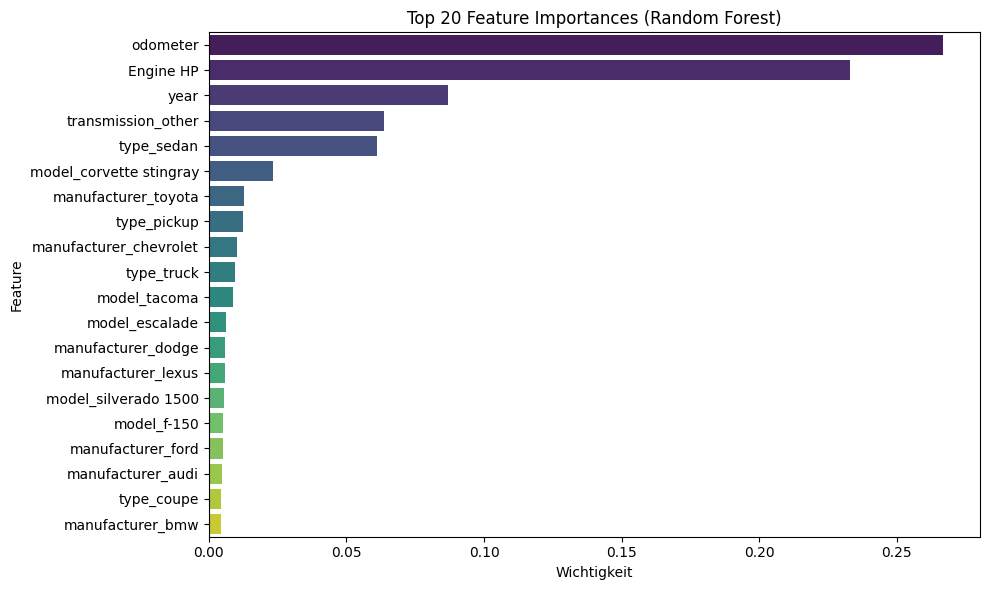

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

# Feature Importances aus dem trainierten Random Forest Modell
importances = random_forest_model.feature_importances_
feature_names = X_train.columns

# In DataFrame für bessere Darstellung
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Top 20 Features anzeigen (optional kannst du die Zahl anpassen)
top_n = 20
top_features = feature_importance_df.head(top_n)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=top_features, x='Importance', y='Feature', palette='viridis')
plt.title(f'Top {top_n} Feature Importances (Random Forest)')
plt.xlabel('Wichtigkeit')
plt.ylabel('Feature')
plt.tight_layout()

plt.savefig("doc/feature_importances.png", dpi=300)

plt.show()


## Build Website

In [ ]:
import gradio as gr
import pandas as pd
import numpy as np
import joblib

# Daten laden
model = joblib.load("car_price_model.pkl")
feature_names = joblib.load("car_model_features.pkl")

# Ursprüngliche Daten laden
df = pd.read_csv("car_data_merged.csv")
df = df[['year', 'odometer', 'Engine HP', 'manufacturer', 'model', 'transmission', 'type']].dropna()

# Modell-Mapping: Hersteller → Modelle
model_map = df.groupby('manufacturer')['model'].unique().to_dict()
manufacturers = sorted(model_map.keys())
transmissions = sorted(df['transmission'].unique())

# Modell-Dropdown aktualisieren bei Herstellerauswahl
def update_model_dropdown(manufacturer):
    models = sorted(model_map.get(manufacturer, []))
    return gr.update(choices=models, value=models[0] if models else None)

# Fahrzeugtyp automatisch bestimmen
def retrieve_car_type(manufacturer, model_name, year):
    filtered = df[
        (df['manufacturer'] == manufacturer) &
        (df['model'] == model_name) &
        (df['year'] == year)
    ]
    if not filtered.empty:
        return filtered.iloc[0]['type']
    else:
        return "other"

def predict_price(year, odometer, engine_hp, manufacturer, model_name, transmission):
    try:
        car_type = retrieve_car_type(manufacturer, model_name, year)

        input_dict = {
            'year': [year],
            'odometer': [odometer],
            'Engine HP': [engine_hp],
            'manufacturer': [manufacturer],
            'model': [model_name],
            'transmission': [transmission],
            'type': [car_type]
        }
        input_df = pd.DataFrame(input_dict)

        # Feature Engineering: Altersgruppe
        input_df['age'] = 2025 - input_df['year']

        labels = ['neu', 'mittel', 'alt', 'sehr alt']
        input_df["age_cat"] = pd.cut(input_df.age, bins=[0, 3, 7, 12, 100], labels=labels)
        input_df['age_cat_encoded'] = input_df['age_cat'].map({
            'neu': 0,
            'mittel': 1,
            'alt': 2,
            'sehr alt': 3
        })
        input_df = input_df.drop(columns=['age', 'age_cat'])

        # Dummy-Codierung
        input_encoded = pd.get_dummies(input_df)

        # Fehlende Spalten ergänzen
        for col in feature_names:
            if col not in input_encoded.columns:
                input_encoded[col] = 0
        input_final = input_encoded[feature_names]

        # Vorhersage
        prediction = model.predict(input_final)[0]
        return f"{int(prediction):,} USD"
    except Exception as e:
        return f"Fehler: {e}"
    
# Test prediction call before launching the app
test_prediction = predict_price(
    year=2015,
    odometer=80000,
    engine_hp=180,
    manufacturer=manufacturers[0],
    model_name=model_map[manufacturers[0]][0],
    transmission=transmissions[0]
)
print("Test prediction:", test_prediction)


# Gradio Interface
with gr.Blocks() as demo:
    gr.Markdown("## Auto-Preis-Vorhersage")

    with gr.Row():
        with gr.Column():
            manufacturer_input = gr.Dropdown(choices=manufacturers, label="Hersteller")
            model_input = gr.Dropdown(choices=[], label="Modell")
            year_input = gr.Number(label="Baujahr", value=2015)
            odometer_input = gr.Number(label="Kilometerstand", value=80000)
            engine_hp_input = gr.Number(label="Motorleistung (HP)", value=180)
            transmission_input = gr.Dropdown(choices=transmissions, label="Getriebeart")

        with gr.Column():
            predict_button = gr.Button("Preis vorhersagen")
            output = gr.Text(label="Vorhergesagter Preis")

    # Modell aktualisieren
    manufacturer_input.change(fn=update_model_dropdown, inputs=manufacturer_input, outputs=model_input)

    # Vorhersage auslösen
    predict_button.click(
        fn=lambda mfr, mdl, yr, odo, hp, tr: predict_price(yr, odo, hp, mfr, mdl, tr),
        inputs=[manufacturer_input, model_input, year_input, odometer_input, engine_hp_input, transmission_input],
        outputs=output
    )

demo.launch()


/tmp/ipykernel_45684/4147166092.py:71: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  input_encoded[col] = 0
/tmp/ipykernel_45684/4147166092.py:71: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  input_encoded[col] = 0
/tmp/ipykernel_45684/4147166092.py:71: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  

Test prediction: 12,002 USD
* Running on local URL:  http://127.0.0.1:7861
* To create a public link, set `share=True` in `launch()`.


/tmp/ipykernel_45684/4147166092.py:71: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  input_encoded[col] = 0
/tmp/ipykernel_45684/4147166092.py:71: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  input_encoded[col] = 0
/tmp/ipykernel_45684/4147166092.py:71: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  